# Overlapping Mixtures of Gaussian Processses

*Valentine Svensson 2015 <br> (with small edits by James Hensman November 2015) 
converted to GPflow by Daniel Marthaler September 2016*

This illustrates use of the OMGP model described in

**Overlapping Mixtures of Gaussian Processes for the data association problem**  
_Miguel Lázaro-Gredilla, Steven Van Vaerenbergh, Neil D. Lawrence_  
Pattern Recognition 2012

The GPclust implementation makes use of the collapsed variational mixture model for GP assignment.

In [1]:
%matplotlib inline
import numpy as np
import GPflow
from GPclust import OMGP
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,6)
from matplotlib import pyplot as plt

## Diverging trend seperation

One application of the OMGP model could be to find diverging trends among populations over time. Imagine for example two species evolving from a common ancestor over time.

We load some pre-generated data which diverge over time.

In [2]:
XY = np.loadtxt('../data/split_data_test.csv', delimiter=',', skiprows=1, usecols=[1, 2])
X = XY[:, 0, None]
Y = XY[:, 1, None]

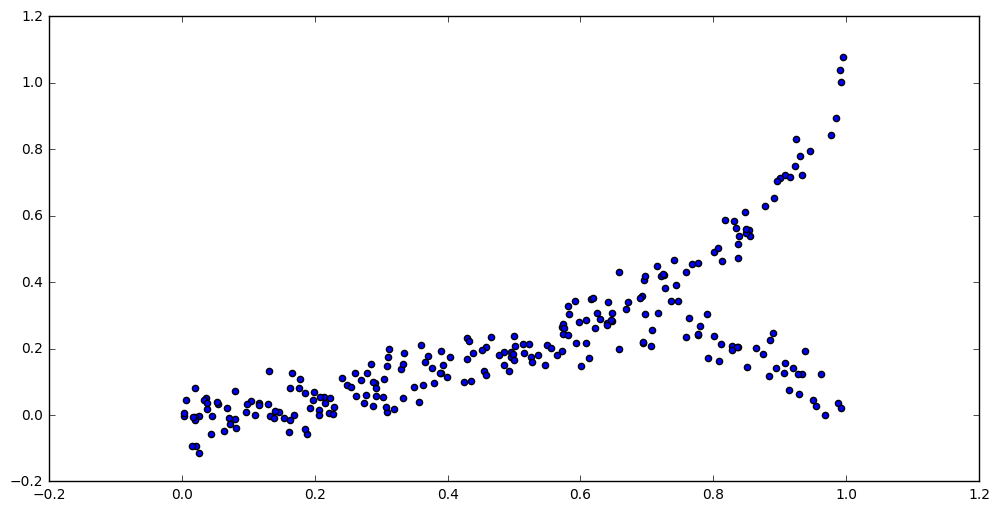

In [3]:
plt.scatter(X, Y);

We define a model assuming `num_clusters` = 2 trends. By default the model will be populated by `num_clusters` RBF kernels. The OMGP implementation is compatible with most kernels in GPflow, so that you for example can encode periodicity in the model.

In [4]:
m = OMGP(X, Y, num_clusters=2, noise_variance=0.01, prior_Z='DP')
m.log_likelihood()

1178.6826028451028

A simple plot function is included which illustrates the asignment probability for each data point, it also shows the posterior mean and confidence intervals for each Gaussian Process.

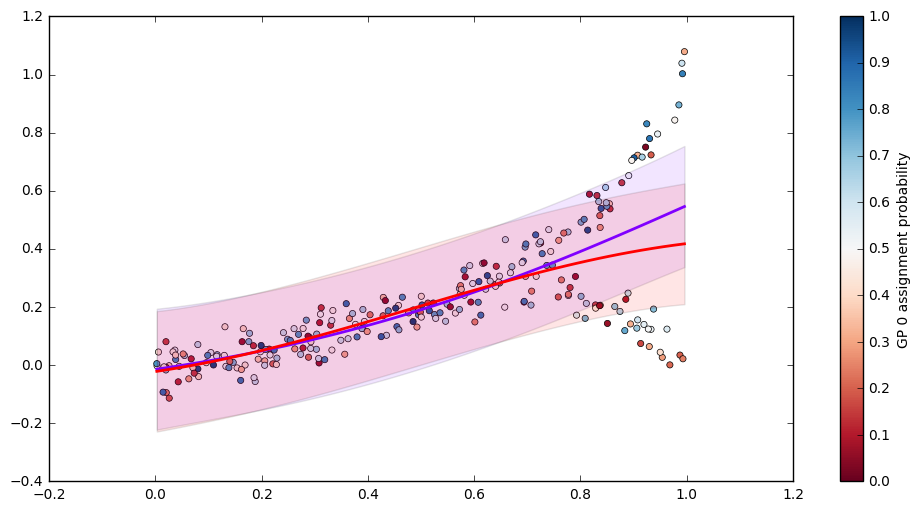

In [5]:
from plotter import OMGPplot
OMGPplot(m,X,Y)

There is also a function for plotting the assignment probability for a given GP directly. Since we haven't optimized the mixture parameters yet the assignment probability is just a random draw from the prior.

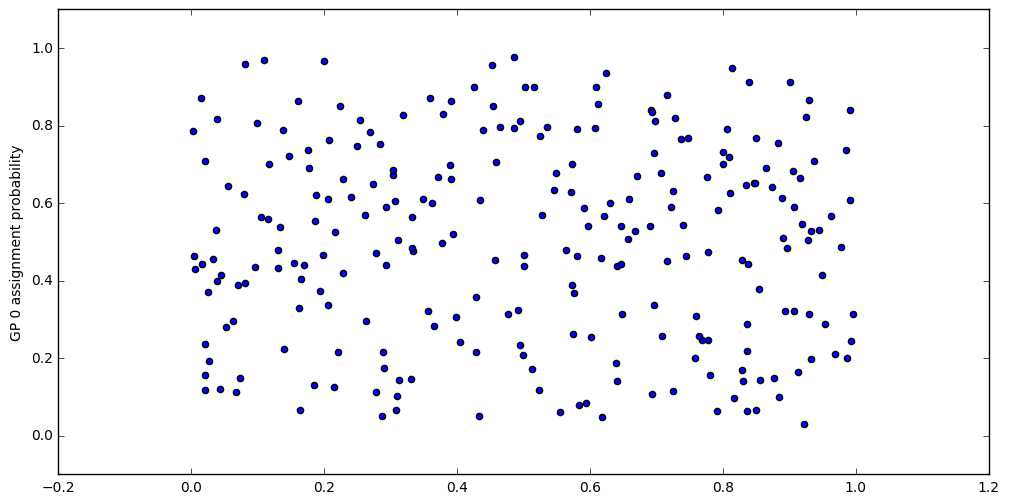

In [6]:
from plotter import OMGPplot_probs
OMGPplot_probs(m, X, gp_num=0)

We can first performa a quick optimization to find the rough trends.

In [7]:
m.optimize(step_length=0.01, maxiter=25)

iteration 1 bound=1184.30386297 grad=362.456813255, beta=0
iteration 2 bound=1191.26300103 grad=337.894640673, beta=1.00251484269
iteration 3 bound=1201.02210783 grad=296.141541061, beta=0.999225197204
iteration 4 bound=1212.67332879 grad=245.293908827, beta=0.984396012779
iteration 5 bound=1224.82748186 grad=191.386149034, beta=0.953462943701
iteration 6 bound=1235.79786591 grad=139.466873105, beta=0.905925304703
iteration 7 bound=1244.29976778 grad=94.6031757014, beta=0.848652961695
iteration 8 bound=1250.04297801 grad=60.5578054969, beta=0.793509025703
iteration 9 bound=1253.54063671 grad=37.8055455355, beta=0.749092827956
iteration 10 bound=1255.54081796 grad=24.0598770715, beta=0.717058949271
iteration 11 bound=1256.66513941 grad=16.2683860937, beta=0.696884665409
iteration 12 bound=1257.32098463 grad=11.9289642991, beta=0.691237122264
iteration 13 bound=1257.74016113 grad=9.41337050754, beta=0.704870868226
iteration 14 bound=1258.0419926 grad=7.80562413642, beta=0.736194096762
it

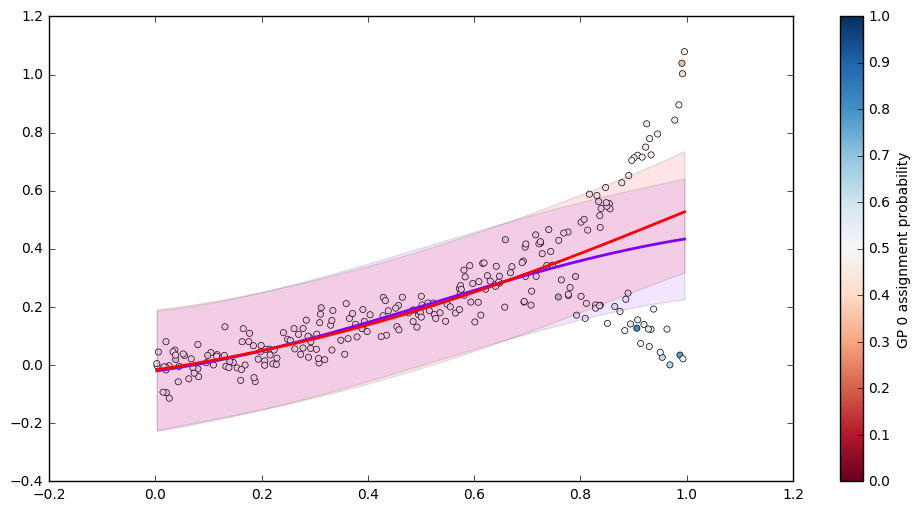

In [8]:
OMGPplot(m,X,Y)

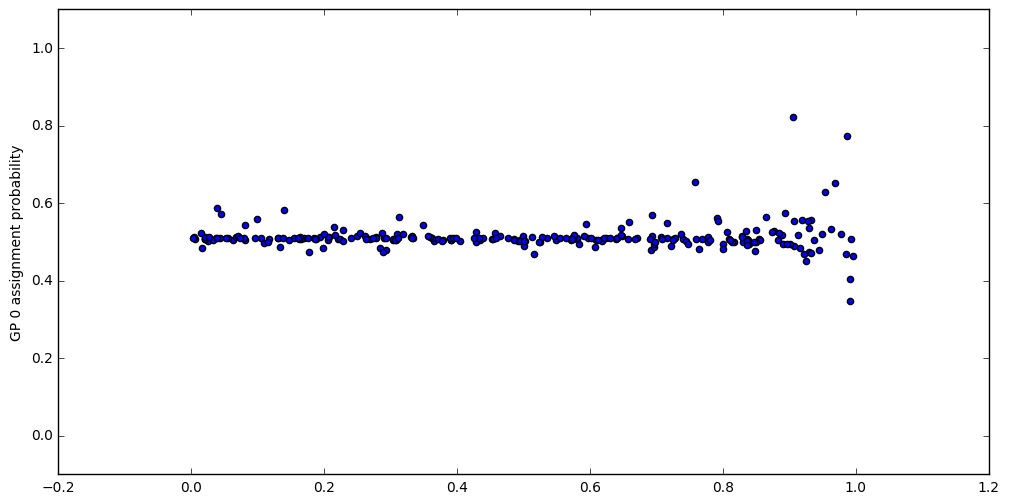

In [9]:
OMGPplot_probs(m,X)

The model identifies the branches of the time series, and in particular the non-branched region have ambigous GP assignment. In this region the two trends share information for prediction.

Like any GPy model the hyper parameters can be inspected.

In [10]:
m

Name,values,prior,constraint
model.noise_variance,[ 0.01],None,+ve
model.kern.item0.variance,[ 1.],None,+ve
model.kern.item0.lengthscales,[ 1.],None,+ve
model.kern.item1.lengthscales,[ 1.],None,+ve
model.kern.item1.variance,[ 1.],None,+ve


We continue by letting the model optimize some more, and also allow it to optimize the hyper parameters. The hyper parameter optimization works best if the mixture parameters have converged or are close to converging.

In [11]:
m.optimize(step_length=0.01, maxiter=200)

iteration 1 bound=1259.53740209 grad=0.883147654447, beta=0
iteration 2 bound=1259.55406623 grad=0.849374835667, beta=0.980609058058
iteration 3 bound=1259.57694596 grad=0.785087372421, beta=0.961099707117
iteration 4 bound=1259.60375664 grad=0.696947173087, beta=0.94155250523
iteration 5 bound=1259.63201377 grad=0.593883533554, beta=0.921943375279
iteration 6 bound=1259.6594229 grad=0.485582949755, beta=0.902279238738
iteration 7 bound=1259.68418898 grad=0.380958061985, beta=0.882589349225
iteration 8 bound=1259.7051864 grad=0.286938709483, beta=0.862922482047
iteration 9 bound=1259.7219743 grad=0.207815150376, beta=0.84334511883
iteration 10 bound=1259.73468442 grad=0.145191467382, beta=0.823943449696
iteration 11 bound=1259.74383566 grad=0.0984393742984, beta=0.804833889177
iteration 12 bound=1259.75013549 grad=0.0654358483795, beta=0.78618896871
iteration 13 bound=1259.75431448 grad=0.0433479375376, beta=0.768289917037
iteration 14 bound=1259.75701741 grad=0.0292824222241, beta=0.7

In [12]:
m

Name,values,prior,constraint
model.noise_variance,[ 1.00000000e-06],None,+ve
model.kern.item0.variance,[ 0.00298939],None,+ve
model.kern.item0.lengthscales,[ 0.05676132],None,+ve
model.kern.item1.lengthscales,[ 6.66041606],None,+ve
model.kern.item1.variance,[ 0.61321391],None,+ve


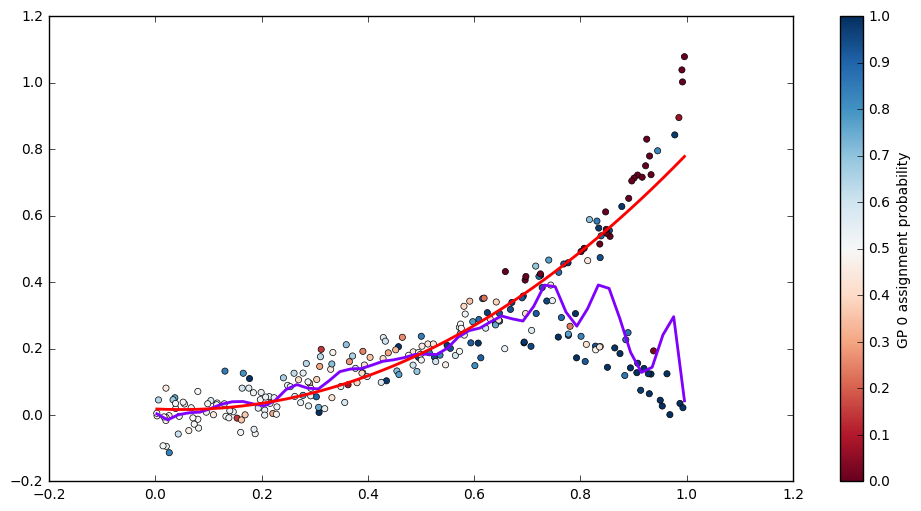

In [13]:
OMGPplot(m,X,Y)

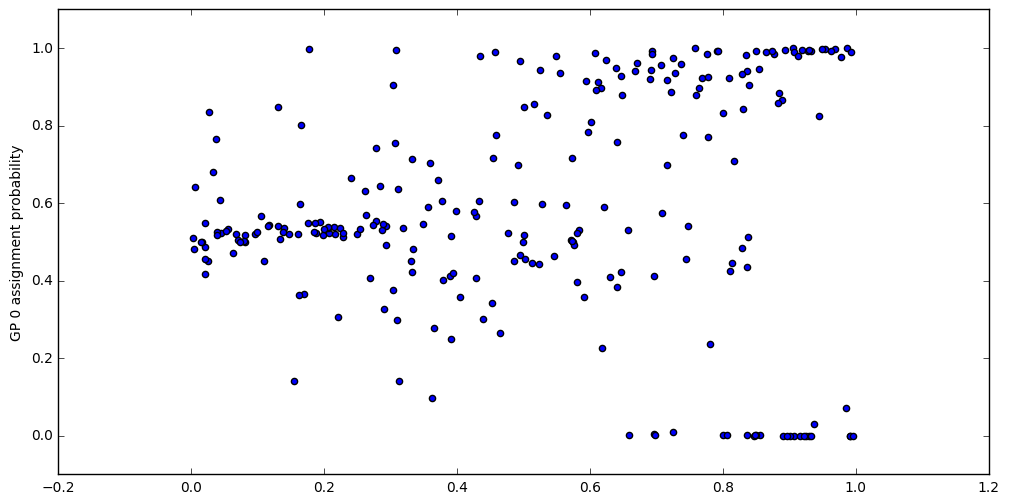

In [14]:
OMGPplot_probs(m,X)

## Separating signal from noise

An interesting application of the OMGP model pointed out in the original publication is the use for robust GP regression.

Let's illustrate this by creating sinusoidal test data with background noise.

In [15]:
x1 = np.random.uniform(0, 10, (100, 1))
x2 = np.random.uniform(0, 10, (100, 1))

y1 = 4 * np.random.randn(*x1.shape)
y2 = 3 * np.sin(x2) + 0.5 * np.random.randn(*x2.shape)
x = np.vstack((x1, x2))
y = np.vstack((y1, y2))

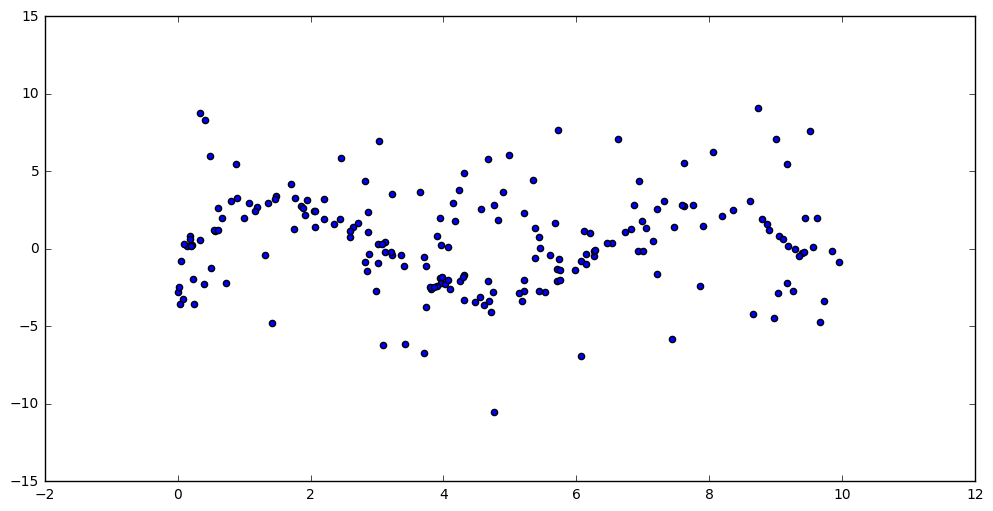

In [16]:
plt.scatter(x, y);

First we make a model with only one mixture component / kernel. This is equivalent to normal GP regression.

In [17]:
kernels = [GPflow.kernels.RBF(1,lengthscales=2.0)]
m = OMGP(x, y, num_clusters=1, prior_Z='DP', kernels=kernels, noise_variance=3.)
m.hyperparam_interval = 100

In [18]:
m.optimize(verbose=False)

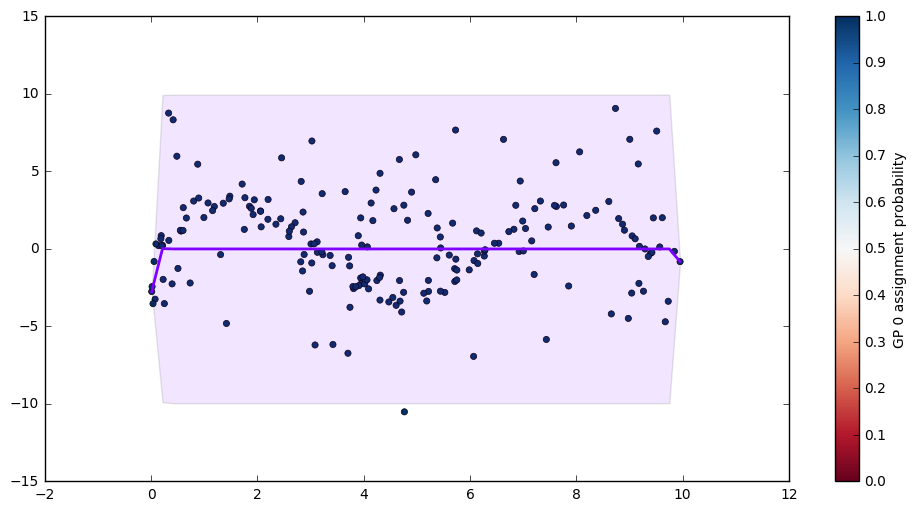

In [19]:
OMGPplot(m,x,y)

Now we in stead view this is a mixture problem, and consider two _different_ kinds of kernels for the different GP components. One encoding white noise, and another which can encode a trend over time (an RBF kernel in this case).

In [20]:
kernels = [GPflow.kernels.White(1), GPflow.kernels.RBF(1, lengthscales=2.0)]
m = OMGP(x, y, num_clusters=2, prior_Z='DP', kernels=kernels, noise_variance=3.)
m.hyperparam_interval = 250

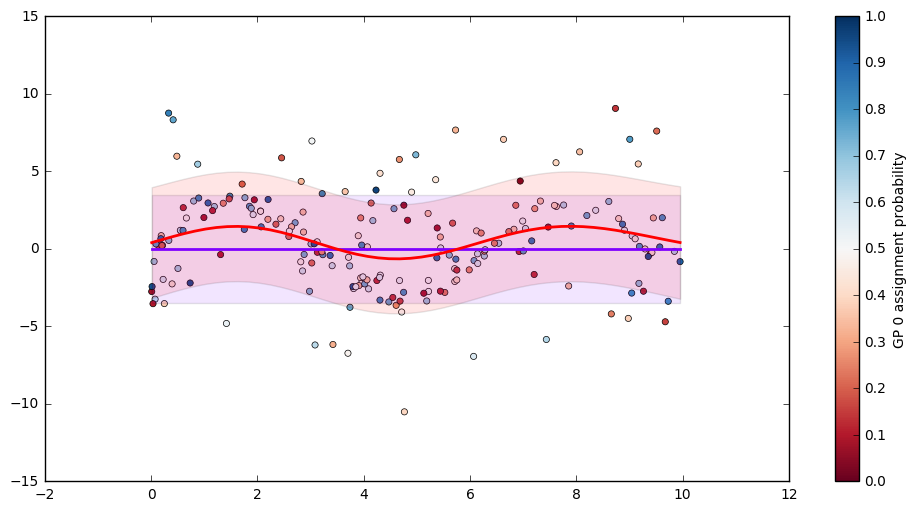

In [21]:
OMGPplot(m,x,y)

In [22]:
m.optimize(step_length=0.01, verbose=False)

In [23]:
m

Name,values,prior,constraint
model.kern.item0.variance,[ 11.75001701],None,+ve
model.kern.item1.lengthscales,[ 3.43468007],None,+ve
model.kern.item1.variance,[ 236.65719826],None,+ve
model.noise_variance,[ 0.44696645],None,+ve


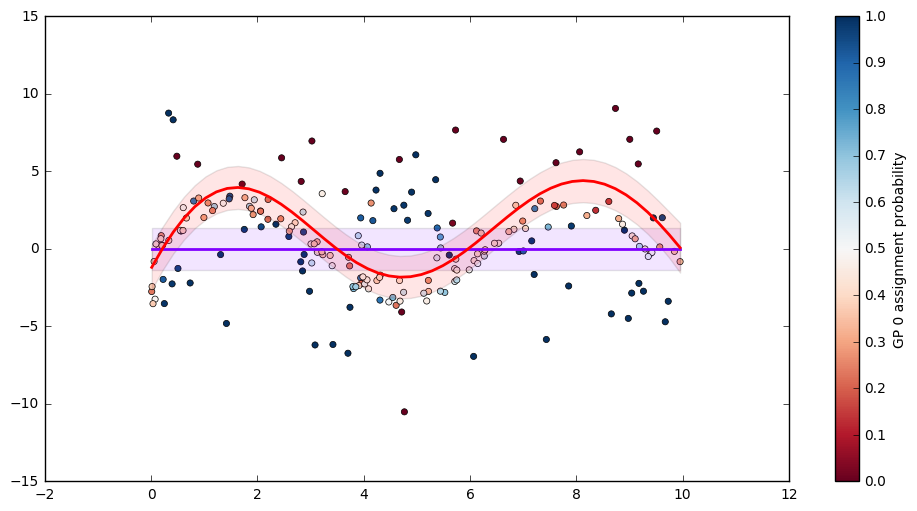

In [24]:
OMGPplot(m,x,y)

The trend over time is much more noticable, and the confidence intervals are smaller.

Noisy points will have high assignment probability to the 'noise GP', while the assignment of the sinusoidal points is ambiguous. We can use this to seperate the points which are more likely to be noise from the remaining points.

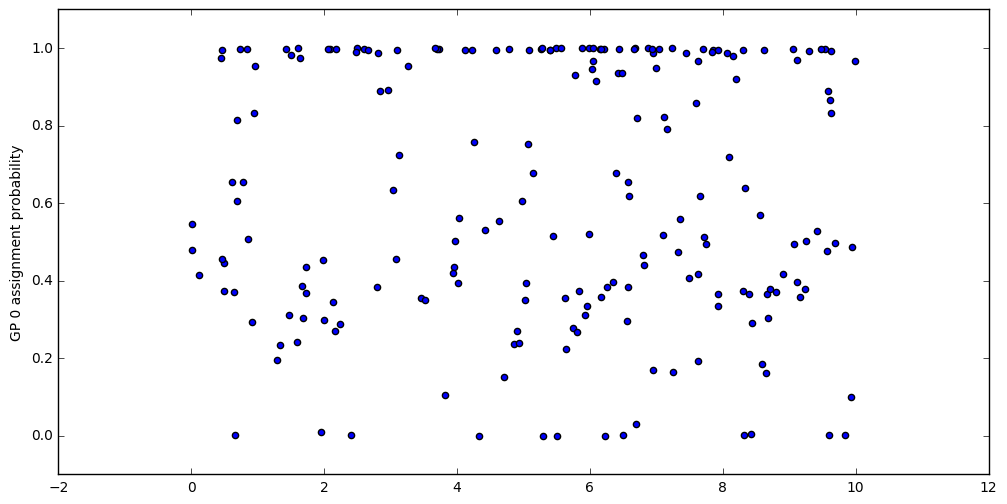

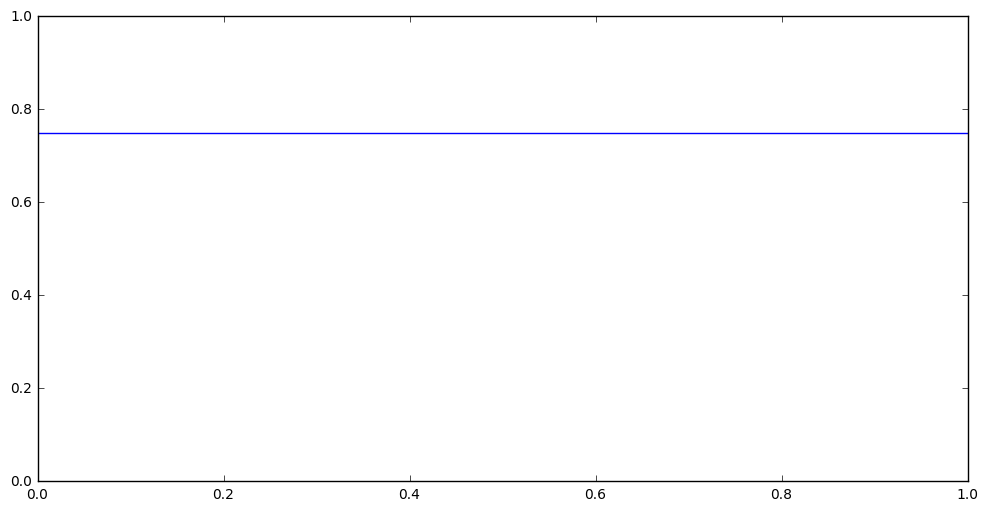

In [29]:
OMGPplot_probs(m,x)
plt.axhline(0.75);

In [30]:
thr = 0.75
phi = m.get_phi()
idx = np.where(phi[:,0] < thr)[0]
nidx = np.where(phi[:,0] >= thr)[0]

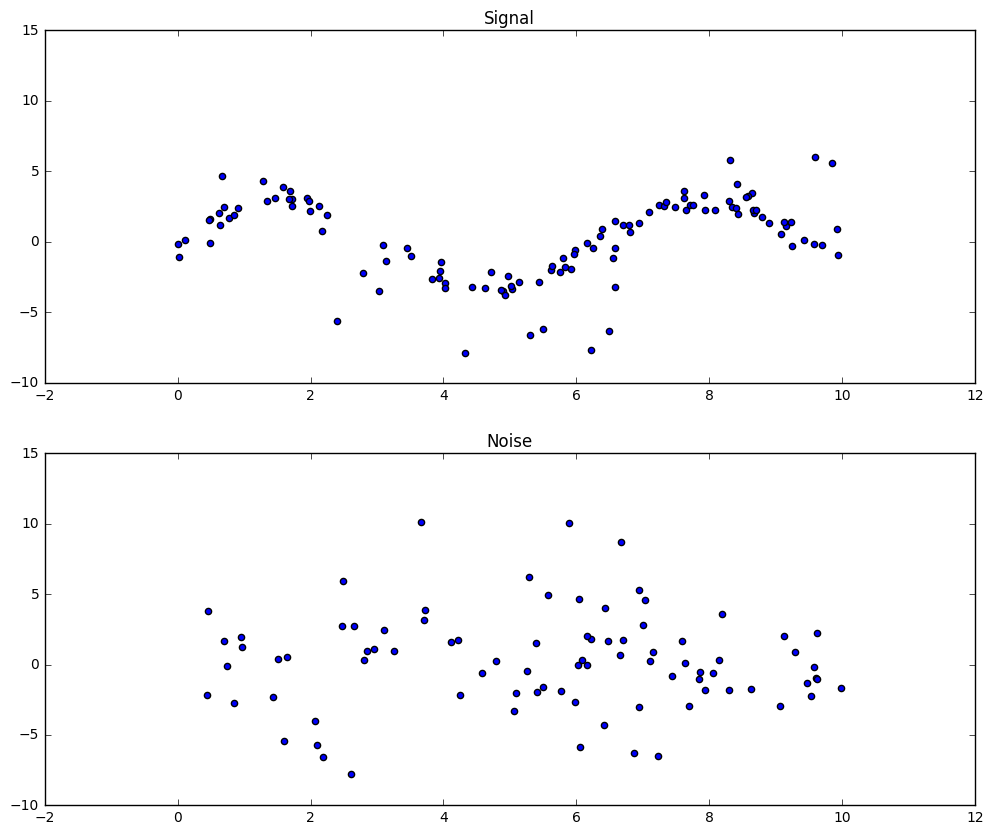

In [31]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.scatter(x[idx], y[idx]);
plt.title('Signal')

plt.subplot(212, sharey=plt.gca())
plt.scatter(x[nidx], y[nidx]);
plt.title('Noise');